In [35]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import glob

path = "./data"

csv_files = glob.glob(path + "/*.csv")
dfs = [pd.read_csv(file) for file in csv_files]
data = pd.concat(dfs, ignore_index=True)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.sort_values(by='Date', ascending=True)
data = data.reset_index(drop=True)

print(data.head())
data.to_csv("./data/tennis_data.csv", index=False)

   ATP  Location          Tournament       Date         Series    Court  \
0    1  Adelaide  AAPT Championships 2001-01-01  International  Outdoor   
1    3      Doha          Qatar Open 2001-01-01  International  Outdoor   
2    3      Doha          Qatar Open 2001-01-01  International  Outdoor   
3    3      Doha          Qatar Open 2001-01-01  International  Outdoor   
4    3      Doha          Qatar Open 2001-01-01  International  Outdoor   

  Surface      Round  Best of          Winner  ...  IWW  IWL   GBW   GBL  SBW  \
0    Hard  1st Round      3.0      Clement A.  ...  NaN  NaN   NaN   NaN  NaN   
1    Hard  1st Round      3.0   Kafelnikov Y.  ...  1.3  2.4  1.27  2.80  NaN   
2    Hard  1st Round      3.0      Jonsson F.  ...  1.9  1.5  2.00  1.57  NaN   
3    Hard  1st Round      3.0       Escude N.  ...  NaN  NaN   NaN   NaN  NaN   
4    Hard  1st Round      3.0  di Pasquale A.  ...  1.8  1.6  1.67  1.85  NaN   

   SBL  BFEW BFEL B&WW B&WL  
0  NaN   NaN  NaN  NaN  NaN  
1 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import glob

file = "./data/tennis_data.csv"
data = pd.read_csv(file)
print(data.shape)

(60717, 59)


/tmp/ipykernel_181340/1759939624.py:10: DtypeWarning: Columns (12,17,18,19,20,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)


In [2]:

def compute_elo(rw, rl, k=32):
    exp_w = 1.0 / (1.0 + 10 ** ((rl - rw) / 400.0))
    delta = k * (1 - exp_w)
    rw_after = rw + delta
    rl_after = rl - delta
    return rw_after, rl_after

def normalize_surface(s):
    if pd.isna(s):
        return None
    s = str(s).strip().lower()
    if 'hard' in s:
        return 'Hard'
    if 'clay' in s:
        return 'Clay'
    if 'grass' in s:
        return 'Grass'
    if 'carpet' in s:
        return 'Carpet'
    return None

def normalize_court(c):
    if pd.isna(c):
        return None
    c = str(c).strip().lower()
    if 'indo' in c:
        return 'Indoors'
    if 'out' in c:
        return 'Outdoors'
    return None

def bin_temperature(temp):
    if temp < 20:
        return 'low'
    elif temp < 28:
        return 'medium'
    else:
        return 'high'

def bin_humidity(hum):
    if hum < 40:
        return 'low'
    elif hum < 70:
        return 'medium'
    else:
        return 'high'


def calculate_player_elo_env_diff(match_data, player_data=None, default_elo=1500, k=32, record_history=True):
    surface_cols = ['Hard_Elo', 'Clay_Elo', 'Grass_Elo', 'Carpet_Elo']
    inout_cols = ['Indoors_Elo', 'Outdoors_Elo']
    temp_cols = ['Temp_Elo_low', 'Temp_Elo_medium', 'Temp_Elo_high']
    hum_cols = ['Hum_Elo_low', 'Hum_Elo_medium', 'Hum_Elo_high']
    all_cols = ['Overall_Elo'] + surface_cols + inout_cols + temp_cols + hum_cols

    if player_data is None:
        player_data = pd.DataFrame(columns=all_cols).set_index(pd.Index([], name='Player'))

    match_records = []
    h2h = defaultdict(int)

    for idx, match in match_data.iterrows():
        winner = match.get('Winner')
        loser = match.get('Loser')
        if pd.isna(winner) or pd.isna(loser):
            continue

        surface = normalize_surface(match.get('Surface'))
        court = normalize_court(match.get('Court'))
        date = match.get('Date', match.get('Data'))
        temp_bin = bin_temperature(match.get('temp_matchday')) if not pd.isna(match.get('temp_matchday')) else None
        hum_bin = bin_humidity(match.get('humidity_matchday')) if not pd.isna(match.get('humidity_matchday')) else None

        for p in (winner, loser):
            if p not in player_data.index:
                player_data.loc[p] = {c: float(default_elo) for c in all_cols}

        winner_h2h_prior = h2h[(winner, loser)]
        loser_h2h_prior = h2h[(loser, winner)]

        rw, rl = float(player_data.loc[winner, 'Overall_Elo']), float(player_data.loc[loser, 'Overall_Elo'])
        rw_after, rl_after = compute_elo(rw, rl, k=k)
        player_data.loc[winner, 'Overall_Elo'] = rw_after
        player_data.loc[loser, 'Overall_Elo'] = rl_after

        rw_s = rl_s = np.nan
        if surface:
            col = f"{surface}_Elo"
            rw_s = float(player_data.loc[winner, col])
            rl_s = float(player_data.loc[loser, col])
            rw_s_after, rl_s_after = compute_elo(rw_s, rl_s, k=k)
            player_data.loc[winner, col] = rw_s_after
            player_data.loc[loser, col] = rl_s_after

        rw_c = rl_c = np.nan
        if court:
            col = f"{court}_Elo"
            rw_c = float(player_data.loc[winner, col])
            rl_c = float(player_data.loc[loser, col])
            rw_c_after, rl_c_after = compute_elo(rw_c, rl_c, k=k)
            player_data.loc[winner, col] = rw_c_after
            player_data.loc[loser, col] = rl_c_after

        def get_climate_elo(player):
            vals = []
            if temp_bin:
                vals.append(player_data.loc[player, f"Temp_Elo_{temp_bin}"])
            if hum_bin:
                vals.append(player_data.loc[player, f"Hum_Elo_{hum_bin}"])
            return np.mean(vals) if vals else np.nan

        rw_climate = get_climate_elo(winner)
        rl_climate = get_climate_elo(loser)
        player_climate_elo_diff_w = rw_climate - rl_climate if not (np.isnan(rw_climate) or np.isnan(rl_climate)) else np.nan
        player_climate_elo_diff_l = rl_climate - rw_climate if not (np.isnan(rw_climate) or np.isnan(rl_climate)) else np.nan

        if temp_bin:
            col = f"Temp_Elo_{temp_bin}"
            rw_t, rl_t = player_data.loc[winner, col], player_data.loc[loser, col]
            rw_t_after, rl_t_after = compute_elo(rw_t, rl_t, k=k)
            player_data.loc[winner, col] = rw_t_after
            player_data.loc[loser, col] = rl_t_after

        if hum_bin:
            col = f"Hum_Elo_{hum_bin}"
            rw_h, rl_h = player_data.loc[winner, col], player_data.loc[loser, col]
            rw_h_after, rl_h_after = compute_elo(rw_h, rl_h, k=k)
            player_data.loc[winner, col] = rw_h_after
            player_data.loc[loser, col] = rl_h_after

        h2h[(winner, loser)] += 1

        if record_history:
            w_rank = pd.to_numeric(match.get('WRank'), errors='coerce')
            l_rank = pd.to_numeric(match.get('LRank'), errors='coerce')

            match_records.append({
                'MatchIndex': idx,
                'Temp_bin' :temp_bin,
                'Hum_bin' : hum_bin,
                'Date': date,
                'Player': winner,
                'Opponent': loser,
                'Outcome': 1,
                'Elo-diff': float(rw) - float(rl),
                'Player_surface_elo_diff': (rw_s - rl_s) if not (np.isnan(rw_s) or np.isnan(rl_s)) else np.nan,
                'Player_court_elo_diff': (rw_c - rl_c) if not (np.isnan(rw_c) or np.isnan(rl_c)) else np.nan,
                'Player_climate_elo_diff': player_climate_elo_diff_w,
                'Rank-diff': w_rank - l_rank,
                'SetsFor': pd.to_numeric(match.get('Wsets'), errors='coerce'),
                'SetsAgainst': pd.to_numeric(match.get('Lsets'), errors='coerce'),
                'Surface': surface,
                'Court': court,
                'H2H_Wins_vs_Opp': winner_h2h_prior,
                'H2H_Losses_vs_Opp': loser_h2h_prior,
                'H2H_Total_prior': winner_h2h_prior + loser_h2h_prior
            })

            # --- Loser record ---
            match_records.append({
                'MatchIndex': idx,
                'Temp_bin' :temp_bin,
                'Hum_bin' : hum_bin,
                'Date': date,
                'Player': loser,
                'Opponent': winner,
                'Outcome': 0,
                'Elo-diff': float(rl) - float(rw),
                'Player_surface_elo_diff': (rl_s - rw_s) if not (np.isnan(rw_s) or np.isnan(rl_s)) else np.nan,
                'Player_court_elo_diff': (rl_c - rw_c) if not (np.isnan(rw_c) or np.isnan(rl_c)) else np.nan,
                'Player_climate_elo_diff': player_climate_elo_diff_l,
                'Rank-diff': l_rank - w_rank,
                'SetsFor': pd.to_numeric(match.get('Lsets'), errors='coerce'),
                'SetsAgainst': pd.to_numeric(match.get('Wsets'), errors='coerce'),
                'Surface': surface,
                'Court': court,
                'H2H_Wins_vs_Opp': loser_h2h_prior,
                'H2H_Losses_vs_Opp': winner_h2h_prior,
                'H2H_Total_prior': winner_h2h_prior + loser_h2h_prior
            })

    match_df = pd.DataFrame(match_records)
    return player_data, match_df



# run and get history
player_data, match_df = calculate_player_elo_env_diff(data, None, default_elo=1500, k=64, record_history=True)




/tmp/ipykernel_181340/4125462032.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: rolling_matches_last7(df.set_index('Date').index.to_series()))


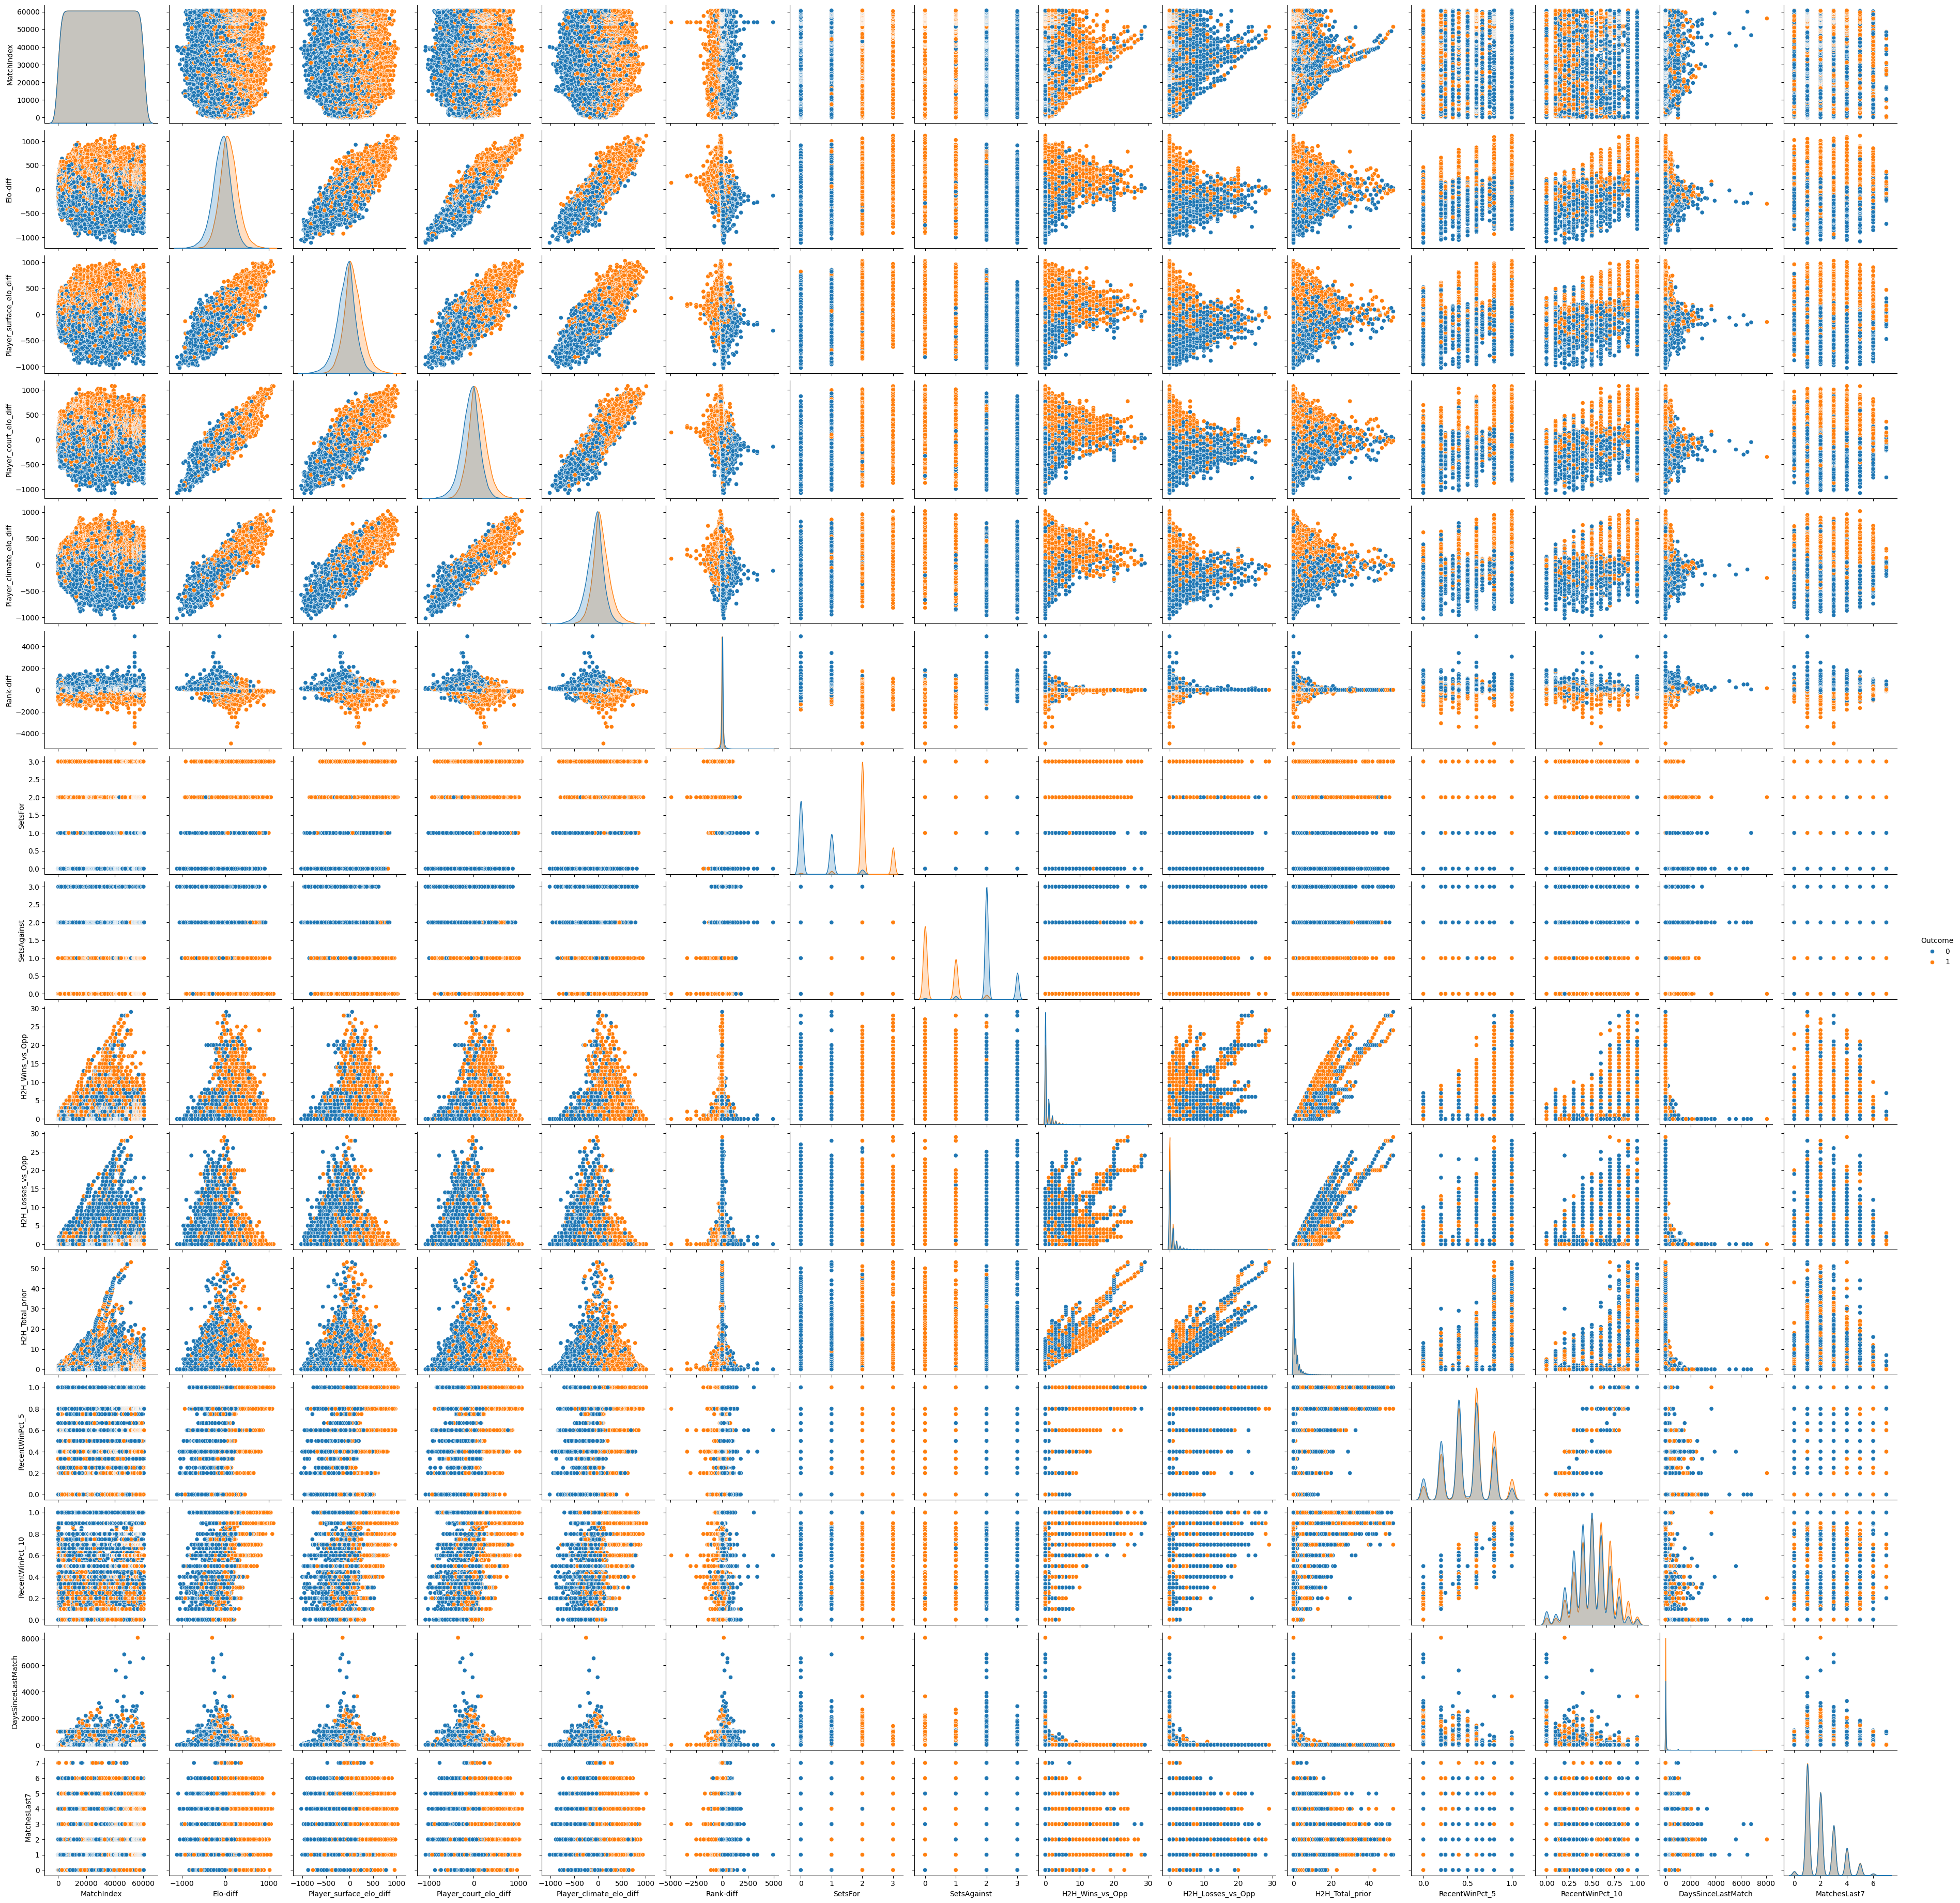

In [4]:
def add_recent_win_rates(match_df):
    match_df = match_df.sort_values(['Player', 'Date']).copy()
    match_df['RecentWinPct_5'] = (
        match_df.groupby('Player')['Outcome']
        .apply(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))
        .reset_index(level=0, drop=True)
    )
    match_df['RecentWinPct_10'] = (
        match_df.groupby('Player')['Outcome']
        .apply(lambda x: x.rolling(window=10, min_periods=1).mean().shift(1))
        .reset_index(level=0, drop=True)
    )
    return match_df

match_df = add_recent_win_rates(match_df)

def add_fatigue_features(match_df):
    match_df = match_df.sort_values(['Player', 'Date']).copy()
    match_df['Date'] = pd.to_datetime(match_df['Date'])

    # Days since last match
    match_df['DaysSinceLastMatch'] = (
        match_df.groupby('Player')['Date']
        .diff()
        .dt.days
    )

    # Matches in last 7 days (fast + robust)
    def rolling_matches_last7(x):
        return x.rolling('7D').count().shift(1)

    match_df['MatchesLast7'] = (
        match_df.groupby('Player', group_keys=False)
        .apply(lambda df: rolling_matches_last7(df.set_index('Date').index.to_series()))
        .reset_index(level=0, drop=True)
    )

    match_df['DaysSinceLastMatch'] = match_df['DaysSinceLastMatch'].fillna(999)
    match_df['MatchesLast7'] = match_df['MatchesLast7'].fillna(0)

    return match_df



match_df = add_fatigue_features(match_df)

sns.pairplot(match_df, hue="Outcome")


In [6]:
print(match_df.columns)




Index(['MatchIndex', 'Temp_bin', 'Hum_bin', 'Date', 'Player', 'Opponent',
       'Outcome', 'Elo-diff', 'Player_surface_elo_diff',
       'Player_court_elo_diff', 'Player_climate_elo_diff', 'Rank-diff',
       'SetsFor', 'SetsAgainst', 'Surface', 'Court', 'H2H_Wins_vs_Opp',
       'H2H_Losses_vs_Opp', 'H2H_Total_prior', 'RecentWinPct_5',
       'RecentWinPct_10', 'DaysSinceLastMatch', 'MatchesLast7'],
      dtype='object')


(97147, 19)


/home/ilpoaunio/Documents/misc-coding/tennis-pred/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:25:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6732820027175032
ROC AUC: 0.741052405846262

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.69      0.68     12174
           1       0.68      0.65      0.67     12113

    accuracy                           0.67     24287
   macro avg       0.67      0.67      0.67     24287
weighted avg       0.67      0.67      0.67     24287



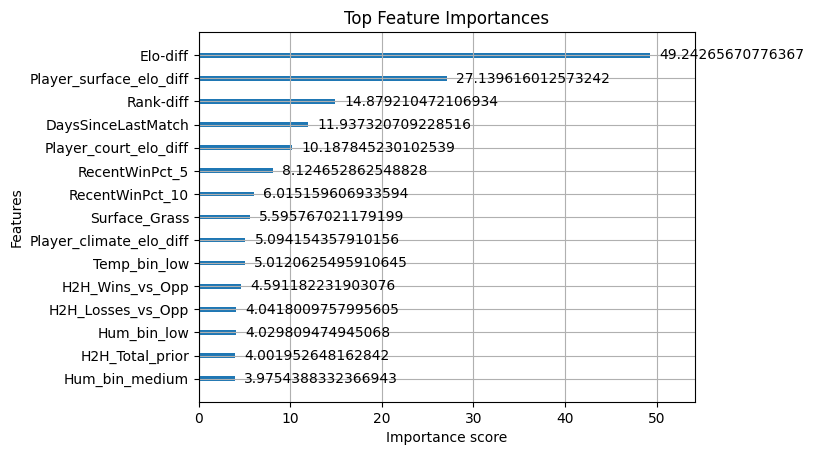

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import xgboost as xgb

df = match_df.copy()

num_features = [
    'Elo-diff',
    'Player_surface_elo_diff',
    'Player_court_elo_diff',
    'Player_climate_elo_diff',
    'Rank-diff',
    'H2H_Wins_vs_Opp',
    'H2H_Losses_vs_Opp',
    'H2H_Total_prior',
    'RecentWinPct_5',
    'RecentWinPct_10',
    'DaysSinceLastMatch',
]

cat_features = ['Surface', 'Court', 'Temp_bin', 'Hum_bin']
feature_cols = num_features + cat_features
X = pd.get_dummies(df[feature_cols], drop_first=True)
y = df['Outcome'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape)
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.title("Top Feature Importances")
plt.show()


In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'n_estimators': [800, 1200],
    'learning_rate': [0.02, 0.05],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5]
}

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=42
)

grid = GridSearchCV(model, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


KeyboardInterrupt: 

In [27]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(model, method='isotonic', cv=5)
calibrator.fit(X_train, y_train)
predictor = calibrator

probs = predictor.predict_proba(X)[:, 1]
match_df = match_df.copy()
match_df['ModelProb'] = probs

print(match_df.head())

/home/ilpoaunio/Documents/misc-coding/tennis-pred/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ilpoaunio/Documents/misc-coding/tennis-pred/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ilpoaunio/Documents/misc-coding/tennis-pred/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ilpoaunio/Documents/misc-coding/tennis-pred/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "

   MatchIndex Temp_bin Hum_bin       Date         Player       Opponent  \
0           0      low  medium 2001-01-01  Kafelnikov Y.     Jonsson F.   
1           0      low  medium 2001-01-01     Jonsson F.  Kafelnikov Y.   
2           1      low  medium 2001-01-01       Arazi H.      Portas A.   
3           1      low  medium 2001-01-01      Portas A.       Arazi H.   
4           2   medium    high 2001-01-01      Tabara M.   Stoliarov A.   

   Outcome  Elo-diff  Player_surface_elo_diff  Player_court_elo_diff  \
0        1       0.0                      0.0                    0.0   
1        0       0.0                      0.0                    0.0   
2        1       0.0                      0.0                    0.0   
3        0       0.0                      0.0                    0.0   
4        1       0.0                      0.0                    0.0   

   Player_climate_elo_diff  Rank-diff  SetsFor  SetsAgainst Surface     Court  \
0                      0.0     -198